In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.special import erf
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
from lens import design
plt.style.use('notes')
%load_ext autoreload
%autoreload 2

path = '/media/robert/Data_Storage/Data/Experimental/Lithium_Oven/Lithium_Oven_Test/'
lam = 0.796
# All length units are in um

In [2]:
# We want to able to vary the location of the first and second optics, the radius of the first optic
r = np.load(path+'r.npy')
E = np.load(path+'e.npy')

In [3]:
# After the plasma we want to know how the laser evolves, particularly peak transverse intensity
Nx = 2**10
X = 10e3
tau = 30
# Load in the transverse field and pulse
pulseParams = {
    'Nt' : 2**6,
    'Nx' : Nx,
    'Ny' : Nx,
    'X' : X,
    'Y' : X,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : True,
    'threads' : 4,
    'cyl' : True,
    'tau' : tau,
    'name' : 'Refracted_Beam',
}
pulse0 = laserpulse.Pulse(pulseParams)

In [8]:
# Beam intensity downstream
Nx = 2**10
X = 40e3
pulseParams['load'] = False
pulseParams['name'] = 'Post_Plasma'
pulseParams['Nx'] = Nx
pulseParams['Ny'] = Nx
pulseParams['X'] = X
pulseParams['Y'] = X
pulse = laserpulse.Pulse(pulseParams)
e0 = np.array(pulse0.e)
e = pulse.e
for i in range(pulse0.Nt):
    e[i, :, :] = pulse.reconstruct_from_cyl(pulse0.x, e0[i, :, int(pulse0.Ny/2)], pulse.x, pulse.y)
pulse.initialize_field(e)

In [9]:
Nz = 100
Z = 4e6
z = np.linspace(0, Z, Nz)
pulse.propagate(z, 1.0)

In [10]:
I = np.zeros((Nz, Nx), dtype='double')
for i in range(Nz):
    I[i, :] = np.amax(pulse.intensity_from_field(pulse.load_field(i)[0]), axis=0)
I = pulse.prep_data(I)

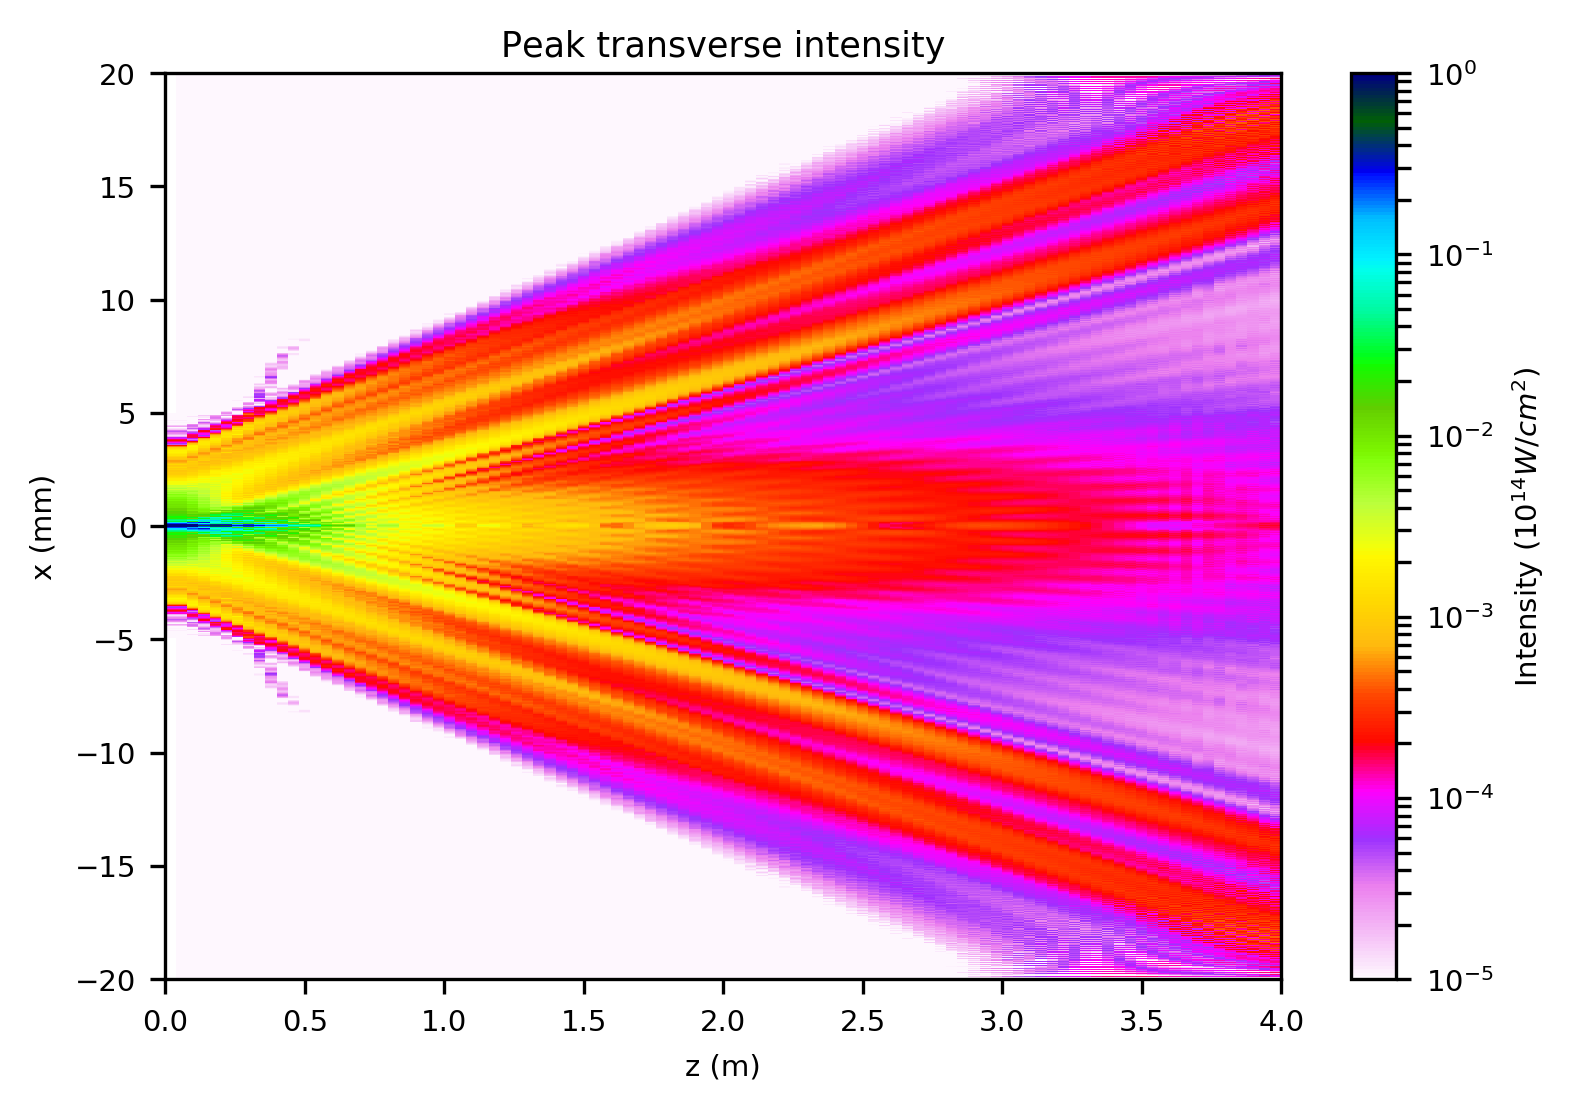

In [18]:
import matplotlib.colors as colors
plt.figure(figsize=(6, 4), dpi=300)
norm = colors.LogNorm(vmin=1e-5, vmax=1)
im = plt.imshow(I, aspect='auto', extent=[0, Z/1e6, -X/2e3, X/2e3], norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14} W/cm^2$)')
plt.set_cmap('gist_ncar_r')
plt.xlabel(r'z (m)')
plt.ylabel(r'x (mm)')
plt.title('Peak transverse intensity')
plt.show()